In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)

from scipy import sparse
from xgboost import XGBClassifier
import joblib

from final_preprocessing import final_common_preprocessing

In [2]:
# ---------------------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------------------
SUFFIX = "_opioid_sample5M_grace15_minspell7_ae_censoring"
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")

demographics_path = BASE / "demographics_opioid_sample5M.parquet"
split_spells_path = BASE / f"split_spells{SUFFIX}.parquet"
icd10_path = BASE / f"icd10_codes_from_spells{SUFFIX}_clustered.parquet"

AE_WINDOW_DAYS = 30

# ---------------------------------------------------------------------
# 2. Load data
# ---------------------------------------------------------------------
print("Loading data...")
dem = pd.read_parquet(demographics_path)
spells = pd.read_parquet(split_spells_path)
icd = pd.read_parquet(icd10_path)

df, numeric_cols, cat_cols = final_common_preprocessing(spells, dem, icd, AE_WINDOW_DAYS)

Loading data...
dem shape:    (824793, 6)
spells shape: (1794387, 14)
icd shape:    (1231909, 4)
spells after drug_combo filter: (1581017, 14)
spells after short no-AE spell filter: (932712, 14) (removed 41.01% rows)
Number of spells with AE 17605
Number of AE within 30 days: 15387
AE within 30 days rate: 0.016497053752926948
Spells before deduplication: 932712
Spells after deduplication: 852289
Number of AE within 30 days after dedup: 15380
Merging tables...
After merging demographics, df shape: (852289, 22)
Combined df shape: (852289, 23)
Number of AE within 30 days after merge: 15380
Number of rows with NaN in birthyear: 2121
Number of rows with None in gender: 0
Filtering out 1290 rows (0.15%) where AE ICD prefix appears in icd10_codes (potential leakage).
Number of AE within 30 days after leakage filter: 14187
Rows remaining after leakage filter: 850999
Dropped 32617 rows with age > 120.
Number of AE within 30 days after dropping missing essential info: 13959
AE within 30 days rat

In [ ]:
# ---------------------------------------------------------------------
# 7. Multi-hot encode drugs & ICD10 groups
# ---------------------------------------------------------------------
# Ensure icd10_codes is list-like; replace NaNs with empty list
def to_list_or_empty(x):
    # already a proper list/tuple
    if isinstance(x, (list, tuple)):
        return list(x)
    
    # numpy array from parquet
    if isinstance(x, np.ndarray):
        return x.tolist()
    
    # explicit None
    if x is None:
        return []
    
    # pandas NA / NaN scalars
    try:
        if pd.isna(x):
            return []
    except TypeError:
        # pd.isna on weird types (like arrays) would error,
        # but we've already handled arrays above.
        pass
    
    # fallback: treat as single code
    return [x]

df["icd10_codes"] = df["icd10_codes"].apply(to_list_or_empty)

# drug_combo is already list-like from earlier filter
df["drug_combo"] = df["drug_combo"].apply(lambda x: list(x))

df["num_drugs_in_spell"] = df["drug_combo"].apply(len)
df["num_icd10_codes"] = df["icd10_codes"].apply(len)
numeric_cols.extend(["num_drugs_in_spell", "num_icd10_codes"])

print("Fitting MultiLabelBinarizer for drugs...")
mlb_drugs = MultiLabelBinarizer(sparse_output=True)
X_drugs = mlb_drugs.fit_transform(df["drug_combo"])

print("Number of drug classes:", len(mlb_drugs.classes_))

# ---------------------------------------------------------------------
# 7b. Multi-hot encode ICD10 groups, but keep only frequent ones
# ---------------------------------------------------------------------

print("Fitting MultiLabelBinarizer for ICD10 groups...")
mlb_icd = MultiLabelBinarizer(sparse_output=True)
X_icd_full = mlb_icd.fit_transform(df["icd10_codes"])
icd_classes = np.array(mlb_icd.classes_)

print("Total ICD10 group features:", len(icd_classes))

# Frequency filter: keep ICD groups that appear in at least min_icd_freq spells
min_icd_freq = 500  # adjust as needed based on dataset size
icd_freq = np.asarray(X_icd_full.sum(axis=0)).ravel()
keep_mask = icd_freq >= min_icd_freq

print(f"ICD groups kept (freq >= {min_icd_freq}): {keep_mask.sum()} out of {len(icd_classes)}")

X_icd = X_icd_full[:, keep_mask]
icd_kept_classes = icd_classes[keep_mask]

# optional: keep for inspection / saving
df["num_icd10_codes"] = df["icd10_codes"].apply(len)
numeric_cols.extend(["num_drugs_in_spell", "num_icd10_codes"])


# ---------------------------------------------------------------------
# 8. One-hot encode demographics & combine all features
# ---------------------------------------------------------------------
print("One-hot encoding demographics...")
X_base = df[numeric_cols + cat_cols].copy()

# Fill numeric NaNs with median
for c in numeric_cols:
    X_base[c] = X_base[c].fillna(X_base[c].median())

X_base = pd.get_dummies(X_base, columns=cat_cols, dummy_na=True)

# Make sure everything is numeric and not object
X_base = X_base.apply(pd.to_numeric, errors="coerce").fillna(0).astype("float32")

# Convert base to sparse and hstack with drugs & icd
X_base_sparse = sparse.csr_matrix(X_base.values)

print("Stacking feature matrices for logreg...")
X = sparse.hstack([X_base_sparse, X_drugs, X_icd]).tocsr()
y = df["y"].values

print("Final feature matrix shape:", X.shape)

# ---------------------------------------------------------------------
# 9. Train/validation split (stratified)
# ---------------------------------------------------------------------
print("Splitting train/validation...")
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f"Train positives: {pos}, negatives: {neg}, scale_pos_weight: {scale_pos_weight:.2f}")

Fitting MultiLabelBinarizer for drugs...
Number of drug classes: 200
Fitting MultiLabelBinarizer for ICD10 groups...
Total ICD10 group features: 1987
ICD groups kept (freq >= 500): 940 out of 1987
One-hot encoding demographics...
Stacking feature matrices for logreg...
Final feature matrix shape: (818382, 1156)
Splitting train/validation...
Train positives: 11167, negatives: 643538, scale_pos_weight: 57.63


## Evaluating the results

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve
)

import joblib

BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/logreg_models")

# Load model and encoders
logreg = joblib.load(BASE / f"logreg_final.joblib")

print("Model loaded.")


Model loaded.


In [5]:
def precision_recall_at_k(y_true, y_proba, frac):
    n = len(y_true)
    k = int(frac * n)
    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]
    precision_k = y_top.mean()            # PPV in the top frac
    recall_k = y_top.sum() / y_true.sum() # proportion of all events captured
    return precision_k, recall_k, k

y_valid_proba = logreg.predict_proba(X_valid)[:, 1]

for frac in [0.001,0.01, 0.05, 0.10]:
    p_k, r_k, k = precision_recall_at_k(y_valid, y_valid_proba, frac)
    print(f"Top {frac*100:.2f}% (n={k}):")
    print(f"  Precision@k: {p_k:.4f}")
    print(f"  Recall@k:    {r_k:.4f}")
    print()


# Build feature name list in the same order as X
base_feature_names = list(X_base.columns)
drug_feature_names = [f"DRUG_{c}" for c in mlb_drugs.classes_]
icd_feature_names  = [f"ICD_{c}" for c in icd_kept_classes]

feature_names = base_feature_names + drug_feature_names + icd_feature_names

coef = logreg.coef_.ravel()
logreg_summary = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "OR": np.exp(coef)
}).sort_values("OR", ascending=False)

print("Top positive features (highest OR):")
print(logreg_summary.head(20))

print("Top negative features (protective):")
print(logreg_summary.tail(20))

Top 0.10% (n=163):
  Precision@k: 0.1840
  Recall@k:    0.0107

Top 1.00% (n=1636):
  Precision@k: 0.1216
  Recall@k:    0.0713

Top 5.00% (n=8183):
  Precision@k: 0.0755
  Recall@k:    0.2213

Top 10.00% (n=16367):
  Precision@k: 0.0590
  Recall@k:    0.3460

Top positive features (highest OR):
        feature      coef        OR
178   DRUG_N06C  0.982559  2.671284
181   DRUG_N07B  0.969091  2.635546
57    DRUG_C01C  0.928315  2.530242
262     ICD_C25  0.891024  2.437624
1017    ICD_T16  0.846390  2.331215
272     ICD_C56  0.761139  2.140713
185   DRUG_P01C  0.755356  2.128369
139   DRUG_J04B  0.726742  2.068331
147   DRUG_L01C  0.703015  2.019833
288     ICD_C92  0.693336  2.000378
109   DRUG_G02C  0.692591  1.998889
284     ICD_C83  0.689312  1.992345
452     ICD_G61  0.677393  1.968738
71    DRUG_C03X  0.654195  1.923593
848     ICD_O62  0.653197  1.921674
213   DRUG_V03A  0.649055  1.913732
484     ICD_H21  0.585764  1.796363
214   DRUG_V04C  0.575423  1.777883
126   DRUG_H04A  0.

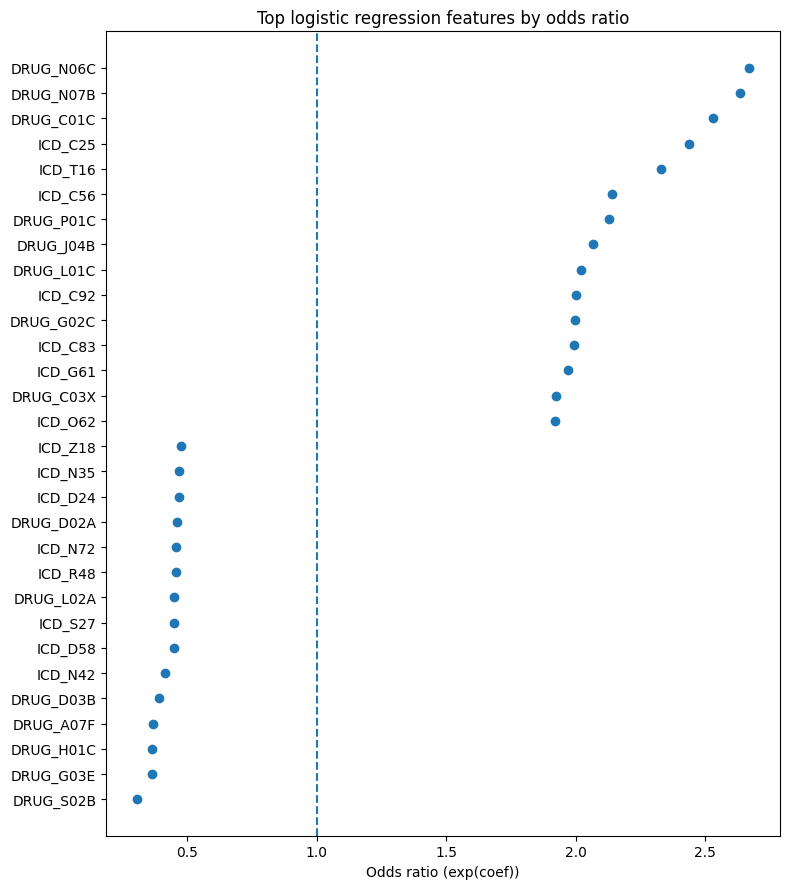

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# logreg_summary is already:
# logreg_summary = pd.DataFrame({
#     "feature": feature_names,
#     "coef": coef,
#     "OR": np.exp(coef)
# }).sort_values("OR", ascending=False)

def plot_odds_ratios(logreg_summary, top_n=30):
    """
    Make a forest-style plot of the top_n features by OR
    (top_n/2 highest ORs and top_n/2 lowest ORs).
    """
    df = logreg_summary.copy()

    # Take top N/2 risk and N/2 protective features
    n_half = top_n // 2

    top_risk = df.sort_values("OR", ascending=False).head(n_half)
    top_prot = df.sort_values("OR", ascending=True).head(n_half)

    # Combine, but keep order (protective at top, then risk)
    plot_df = pd.concat([top_prot, top_risk], axis=0)

    # For nicer labels: shorten very long names
    def shorten(name, maxlen=40):
        return (name[:maxlen] + "…") if len(name) > maxlen else name

    plot_df = plot_df.copy()
    plot_df["label"] = plot_df["feature"].apply(shorten)

    # Sort so that it appears nicely from low OR to high OR
    plot_df = plot_df.sort_values("OR", ascending=True)

    # Plot
    fig, ax = plt.subplots(figsize=(8, max(6, 0.3 * len(plot_df))))

    y_pos = np.arange(len(plot_df))

    ax.scatter(plot_df["OR"], y_pos)

    # Vertical line at OR = 1 (no effect)
    ax.axvline(1.0, linestyle="--")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df["label"])
    ax.set_xlabel("Odds ratio (exp(coef))")
    ax.set_title("Top logistic regression features by odds ratio")

    plt.tight_layout()
    plt.show()

# usage:
plot_odds_ratios(logreg_summary, top_n=30)
